In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    classification_report
)
import pickle

In [14]:
def process_embeddings_and_train(file_path, output_path):
    # Load data
    data = pd.read_pickle(file_path)

    # Separate features and labels
    X = data[[col for col in data.columns if col.startswith("emb_")]].values  # Select embedding columns
    y = data['label'].values

    # Define class weights
    class_weights = {0: 1, 1: 4}

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    # Standardize features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Define classifiers with hyperparameter grids
    classifiers = {
        "Random Forest": {
            "model": RandomForestClassifier(random_state=42, class_weight=class_weights),
            "params": {
                "n_estimators": [50, 100, 200],
                "max_depth": [5,10, 20, None],
                "min_samples_split": [2, 5, 10]
            }
        },
        "Bagging": {
            "model": BaggingClassifier(estimator=RandomForestClassifier(random_state=42, class_weight=class_weights), random_state=42),
            "params": {
                "n_estimators": [10, 50, 100],
                "max_samples": [0.5, 0.7, 1.0]
            }
        },
        "XGBoost": {
            "model": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
            "params": {
                "n_estimators": [50, 100, 200],
                "max_depth": [3, 6, 10],
                "learning_rate": [0.01, 0.1, 0.3]
            }
        },
        "SVM": {
            "model": SVC(probability=True, class_weight=class_weights, random_state=42),
            "params": {
                "C": [0.1, 1, 10],
                "kernel": ["linear", "rbf", "poly"],
                "gamma": ["scale", "auto"]
            }
        }
    }

    # Train and evaluate each classifier
    results = {}
    for clf_name, clf_info in classifiers.items():
        print(f"\nTuning {clf_name}...")
        grid_search = GridSearchCV(
            estimator=clf_info["model"],
            param_grid=clf_info["params"],
            scoring='f1_macro',
            cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
            n_jobs=-1
        )
        grid_search.fit(X_train, y_train)

        # Best model
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_

        # Evaluate on the test set
        y_pred = best_model.predict(X_test)
        metrics = {
            "f1_micro": f1_score(y_test, y_pred, average='micro'),
            "f1_macro": f1_score(y_test, y_pred, average='macro'),
            "precision_macro": precision_score(y_test, y_pred, average='macro'),
            "recall_macro": recall_score(y_test, y_pred, average='macro'),
            "accuracy": accuracy_score(y_test, y_pred),
            "classification_report": classification_report(y_test, y_pred)
        }

        # Save results
        results[clf_name] = {
            "best_params": best_params,
            "metrics": metrics
        }

        # Print metrics and best parameters
        print(f"\n{clf_name} Results:")
        print(f"Best Parameters: {best_params}")
        for metric, value in metrics.items():
            if metric != "classification_report":
                print(f"{metric.capitalize()}: {value:.4f}")
            else:
                print(f"\n{metric.capitalize()}:\n{value}")

    # Plot F1 Macro Scores
    f1_scores = {clf: result['metrics']['f1_macro'] for clf, result in results.items()}
    plt.figure(figsize=(10, 6))
    plt.bar(f1_scores.keys(), f1_scores.values())
    plt.title('F1 Macro Scores of Classifiers')
    plt.xlabel('Classifier')
    plt.ylabel('F1 Macro Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Plot Accuracies
    accuracies = {clf: result['metrics']['accuracy'] for clf, result in results.items()}
    plt.figure(figsize=(10, 6))
    plt.bar(accuracies.keys(), accuracies.values())
    plt.title('Accuracy of Classifiers')
    plt.xlabel('Classifier')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Save all results to output path
    with open(output_path, "wb") as f:
        pickle.dump(results, f)
    print(f"\nResults saved to {output_path}")



# Codebert

In [ ]:
# AVG Embeddings
print("Classification using AVG embeddings")
file_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/dataset/data_class/codebert_embeddings/processed_embeddings/codebert_base_embed_line_by_line_avg.pkl"
output_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/codebert/result_codebert_base_avg.pkl"  
process_embeddings_and_train(file_path, output_path)


Classification using AVG embeddings

Tuning Random Forest...


Classification using SUM embeddings

Tuning Random Forest...

Random Forest Results:
Best Parameters: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 50}
F1_micro: 0.7921
F1_macro: 0.5902
Precision_macro: 0.5846
Recall_macro: 0.5986
Accuracy: 0.7921

Classification_report:
              precision    recall  f1-score   support

           0       0.89      0.86      0.88       786
           1       0.28      0.33      0.30       123

    accuracy                           0.79       909
   macro avg       0.58      0.60      0.59       909
weighted avg       0.81      0.79      0.80       909


Tuning Bagging...

Bagging Results:
Best Parameters: {'max_samples': 1.0, 'n_estimators': 10}
F1_micro: 0.8372
F1_macro: 0.6049
Precision_macro: 0.6243
Recall_macro: 0.5938
Accuracy: 0.8372

Classification_report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       786
           1       0.36      0.26      0.30       123

    accura

c:\ProgramData\anaconda3\envs\python_3.9\lib\site-packages\xgboost\core.py:158: UserWarning: [11:49:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Results:
Best Parameters: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 200}
F1_micro: 0.8273
F1_macro: 0.5720
Precision_macro: 0.5894
Recall_macro: 0.5641
Accuracy: 0.8273

Classification_report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       786
           1       0.30      0.20      0.24       123

    accuracy                           0.83       909
   macro avg       0.59      0.56      0.57       909
weighted avg       0.80      0.83      0.81       909


Tuning SVM...

SVM Results:
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
F1_micro: 0.7943
F1_macro: 0.6175
Precision_macro: 0.6069
Recall_macro: 0.6376
Accuracy: 0.7943

Classification_report:
              precision    recall  f1-score   support

           0       0.90      0.85      0.88       786
           1       0.31      0.42      0.36       123

    accuracy                           0.79       909
   macro avg       0.61      0

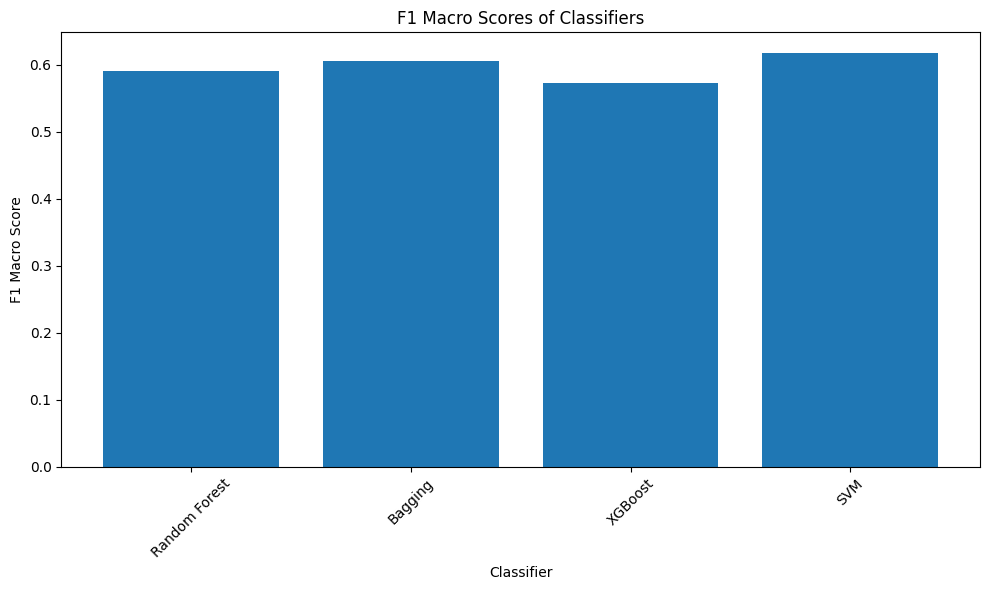

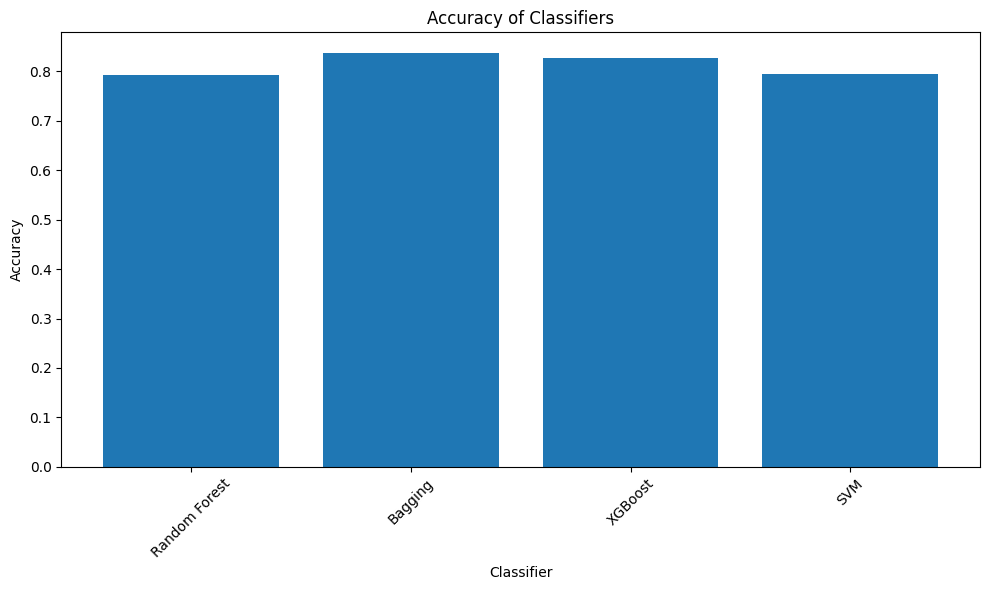


Results saved to C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/codebert/result_codebert_base_sum.pkl


In [12]:
# SUM Embeddings
print("Classification using SUM embeddings")
file_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/dataset/data_class/codebert_embeddings/processed_embeddings/codebert_base_embed_line_by_line_sum.pkl"
output_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/codebert/result_codebert_base_sum.pkl"  
process_embeddings_and_train(file_path, output_path)

# codeT5 base

In [ ]:
# AVG Embeddings
print("Classification using AVG embeddings")
file_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/dataset/data_class/codeT5_embeddings/processed_embeddings/codeT5_base_embed_line_by_line_avg.pkl"
output_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/codeT5/base/result_codeT5_base_avg.pkl"  
process_embeddings_and_train(file_path, output_path)


In [ ]:
# SUM Embeddings
print("Classification using SUM embeddings")
file_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/dataset/data_class/codeT5_embeddings/processed_embeddings/codeT5_base_embed_line_by_line_sum.pkl"
output_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/codeT5/base/result_codeT5_base_sum.pkl"  
process_embeddings_and_train(file_path, output_path)

# codeT5 small

In [ ]:
# AVG Embeddings
print("Classification using AVG embeddings")
file_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/dataset/data_class/codeT5_embeddings/processed_embeddings/codeT5_small_embed_line_by_line_avg.pkl"
output_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/codeT5/small/result_codeT5_small_avg.pkl"  
process_embeddings_and_train(file_path, output_path)

In [ ]:
# SUM Embeddings
print("Classification using SUM embeddings")
file_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/dataset/data_class/codeT5_embeddings/processed_embeddings/codeT5_small_embed_line_by_line_sum.pkl"
output_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/codeT5/small/result_codeT5_small_sum.pkl"  
process_embeddings_and_train(file_path, output_path)

# Cubert

In [ ]:
# AVG Embeddings
print("Classification using AVG embeddings")
file_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/dataset/data_class/cubert_embeddings/processed_embeddings/cubert_embed_line_by_line_avg.pkl"
output_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/cubert/result_cubert_avg.pkl"  
process_embeddings_and_train(file_path, output_path)


In [ ]:
# SUM Embeddings
print("Classification using SUM embeddings")
file_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/dataset/data_class/cubert_embeddings/processed_embeddings/cubert_embed_line_by_line_sum.pkl"
output_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/cubert/result_cubert_sum.pkl"  
process_embeddings_and_train(file_path, output_path)

# Plbart-base

In [ ]:
# AVG Embeddings
print("Classification using AVG embeddings")
file_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/dataset/data_class/plbart_base_embeddings/processed_embeddings/plbart_embed_line_by_line_avg.pkl"
output_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/plbart/result_plbart_avg.pkl"  
process_embeddings_and_train(file_path, output_path)


In [ ]:
# SUM Embeddings
print("Classification using SUM embeddings")
file_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/dataset/data_class/plbart_base_embeddings/processed_embeddings/plbart_embed_line_by_line_sum.pkl"
output_path = "C:/Users/Rohan/Downloads/Code_Smell_Detection-20241216T154125Z-001/Code_Smell_Detection/data_class/results/plbart/result_plbart_sum.pkl"  
process_embeddings_and_train(file_path, output_path)